In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [2]:
import pandas as pd
import numpy as np
from bayesian.train_bn import component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.sampling import generate_synthetics
from bayesian.subsample import get_subsample
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN
from bayesian.calculate_accuracy import calculate_acc, LOO_validation
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from copy import copy
from external.libpgm.sampleaggregator import SampleAggregator
import operator
from sklearn.metrics import accuracy_score, mean_squared_error
from scipy import stats
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import math
from pomegranate import DiscreteDistribution
import random
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from gmr import MVN
from sklearn.datasets import make_spd_matrix
from sklearn.linear_model import LinearRegression
from sklearn.cluster import DBSCAN
from sklearn.covariance import EllipticEnvelope
from numpy import percentile
from scipy.stats import binned_statistic
import time
from joblib import Parallel, delayed
import cpuinfo

In [3]:
random_state = check_random_state(0)

## Эксперимент на проверку точности генератора


In [7]:
mean_param = []
cov_param = []
w_param = []
LL_theoretical = []
samples = []

In [8]:
beta = [0.8]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    for n in range(1, 11, 1):
        print(n)
        means = []
        cov = []
        w = [1/n for _ in range(n)]
        for _ in range(n):
            means.append([random.randint(-1000, 1000)])
            cov.append([[random.randint(100, 500)]])
        mean_param.append(means)
        cov_param.append(cov)
        w_param.append(w)
        generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
        sample = generator.sample(10000000)
        samples.append(sample)
        m = GaussianMixture(n_components=n).fit(sample)
        LL = round(m.lower_bound_,3)
        LL_theoretical.append(LL)
        for k in range(10):
            print(k)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                #train = sample[0:size+1]
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(sample)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue

1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


In [12]:
beta = [0.9]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res2 = [[] for j in range(10)]
    for n in range(1, 11, 1):
        print(n)
        means = mean_param[n-1]
        cov = cov_param[n-1]
        w = w_param[n-1]
        generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
        test = samples[n-1]
        LL = LL_theoretical[n-1]
        for k in range(10):
            print(k)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                # train = sample[0:size+1]
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res2[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res2[n-1].append(size)
                        break
                    else:
                        continue

1
0
1
2
3
4
5
6
7
8
9
2
0
1
2
3
4
5
6
7
8
9
3
0
1
2
3
4
5
6
7
8
9
4
0
1
2
3
4
5
6
7
8
9
5
0
1
2
3
4
5
6
7
8
9
6
0
1
2
3
4
5
6
7
8
9
7
0
1
2
3
4
5
6
7
8
9
8
0
1
2
3
4
5
6
7
8
9
9
0
1
2
3
4
5
6
7
8
9
10
0
1
2
3
4
5
6
7
8
9


In [34]:
beta = [0.8]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res1 = [[] for j in range(10)]
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = mean_param[n-1]
            cov = cov_param[n-1]
            w = w_param[n-1]
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            # sample = generator.sample(10000000)
            # m = GaussianMixture(n_components=n).fit(sample)
            LL = LL_theoretical[n-1]#round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res1[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res1[n-1].append(size)
                        break
                    else:
                        continue

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


## 1D эксперимент

In [25]:
beta = [0.85]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    mean_param = []
    cov_param = []
    w_param = []
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = []
            cov = []
            w = [1/n for _ in range(n)]
            for i in range(n):
                means.append([random.randint(-1000, 1000)])
                cov.append([[random.randint(100, 500)]])
            mean_param.append(means)
            cov_param.append(cov)
            w_param.append(w)
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            sample = generator.sample(10000000)
            m = GaussianMixture(n_components=n).fit(sample)
            LL = round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 2000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue
            if size == 10000000-1:
                mean_res[n-1].append(size)
    # mean_vector = np.sum(mean_res, axis=0)
    # mean_vector = [u/1 for u in mean_vector]
    # results[number] = mean_vector

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


## 3D эксперимент

In [5]:
beta = [0.99]
results = [[] for i in range (1)]
for number, b in enumerate(beta):
    mean_res = [[] for j in range(10)]
    mean_param = []
    cov_param = []
    w_param = []
    for k in range(10):
        print(k)
        for n in range(1, 11, 1):
            print(n)
            means = []
            cov = []
            w = [1/n for _ in range(n)]
            for i in range(n):
                means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
                cov.append(make_spd_matrix(3))
            mean_param.append(means)
            cov_param.append(cov)
            w_param.append(w)
            generator = GMM(n_components=n, means=means, covariances=cov, priors=w, random_state=random_state)
            sample = generator.sample(10000000)
            m = GaussianMixture(n_components=n).fit(sample)
            LL = round(m.lower_bound_,3)
            test = generator.sample(10000000)
            for size in range (n+1,10000000,1):
                train = generator.sample(size)
                m1 = GaussianMixture(n_components=n).fit(train)
                ll_test = round(np.mean(m1.score_samples(test)),3)
                diff = LL - ll_test
                if diff <= -1*math.log(b):
                    mean_res[n-1].append(size)
                    break
                else:
                    if size > 5000:
                        mean_res[n-1].append(size)
                        break
                    else:
                        continue
            if size == 10000000-1:
                mean_res[n-1].append(size)

0
1
2
3
4
5
6
7
8
9
10
1
1
2
3
4
5
6
7
8
9
10
2
1
2
3
4
5
6
7
8
9
10
3
1
2
3
4
5
6
7
8
9
10
4
1
2
3
4
5
6
7
8
9
10
5
1
2
3
4
5
6
7
8
9
10
6
1
2
3
4
5
6
7
8
9
10
7
1
2
3
4
5
6
7
8
9
10
8
1
2
3
4
5
6
7
8
9
10
9
1
2
3
4
5
6
7
8
9
10


Text(0, 0.5, 'Sample size')

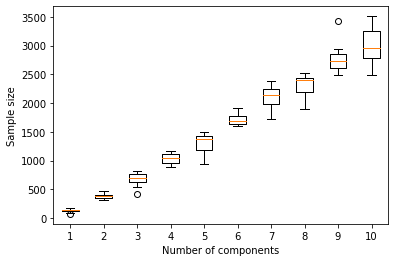

In [10]:
plt.boxplot(mean_res)
plt.xlabel('Number of components')
plt.ylabel('Sample size')

## GMR визуализация

In [6]:
data = pd.read_csv('../data/daks_processed.csv')
columns = ['Tectonic regime', 'Period', 'Lithology', 'Structural setting', 'Depositional environment', 'Gross','Netpay','Porosity','Permeability', 'Depth']
data = data[columns]
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)
data

,Tectonic regime,Period,Lithology,Structural setting,Depositional environment,Gross,Netpay,Porosity,Permeability,Depth
0,COMPRESSION,JURASSIC,LIMESTONE,FORELAND,HIGH-ENERGY RAMP SAND,76.2,56.1,21.0,410.0,1844.5
1,EXTENSION,CRETACEOUS,SANDSTONE,RIFT,MEANDERING RIVER,227.1,43.9,10.0,8.0,3134.8
2,STRIKE-SLIP,NEOGENE,THINLY-BEDDED SANDSTONE,WRENCH,FLUVIAL-DOMINATED DELTA,35.1,20.1,22.0,200.0,3000.9
3,STRIKE-SLIP,NEOGENE,SANDSTONE,WRENCH,BRAIDED RIVER,155.2,125.0,20.0,300.0,3200.9
4,COMPRESSION,CRETACEOUS,LIMESTONE,SALT,SHELF-,76.2,30.5,21.0,60.0,1510.7
...,...,...,...,...,...,...,...,...,...,...
512,EXTENSION,PALEOGENE,SANDSTONE,RIFT,LACUSTRINE FAN-DELTA,50.0,18.9,23.2,121.0,1439.3
513,EXTENSION,PALEOGENE,SANDSTONE,RIFT,SUBLACUSTRINE FAN,89.9,24.1,21.0,60.0,2310.7
514,EXTENSION,MESOZOIC,VOLCANICS,RIFT,NOT APPLICABLE,150.0,59.1,12.7,3.6,3000.9
515,COMPRESSION,CARBONIFEROUS,SANDSTONE,FORELAND,SHORELINE,79.9,10.1,24.0,30.0,570.1


In [7]:
def lrts_comp(data):
    n = 0
    biggets_p = -1*np.infty
    comp_biggest = 0
    max_comp = 10
    if len(data) < max_comp:
        max_comp = len(data)
    for i in range (1, max_comp+1, 1):
        gm1 = GaussianMixture(n_components=i, random_state=0)
        gm2 = GaussianMixture(n_components=i+1, random_state=0)
        gm1.fit(data)
        ll1 = np.mean(gm1.score_samples(data))
        gm2.fit(data)
        ll2 = np.mean(gm2.score_samples(data))
        LR = 2*(ll2 - ll1)
        p = chi2.sf(LR, 1)    
        if p > biggets_p:
            biggets_p = p
            comp_biggest = i
        n = comp_biggest
    return n

def mix_norm_cdf(x, weights, means, covars):
    mcdf = 0.0
    for i in range(len(weights)):
        mcdf += weights[i] * stats.norm.cdf(x, loc=means[i][0], scale=covars[i][0][0])
    return mcdf

def theoretical_quantile (data, n_comp):
    model = GaussianMixture(n_components=n_comp,random_state=0)
    model.fit(data)
    q = []
    x = []
    #step =  ((np.max(model.sample(100000)[0])) - (np.min(model.sample(100000)[0])))/1000
    step =  (np.max(data) - np.min(data))/1000
    d = np.arange(np.min(data),np.max(data), step)
    for i in d:
        x.append(i)
        q.append(mix_norm_cdf(i,model.weights_, model.means_, model.covariances_))
    return x, q

def quantile_mix(p, vals, q):
    ind = q.index(min(q, key=lambda x:abs(x-p)))
    return vals[ind]
def probability_mix(val, vals, q):
    ind = vals.index(min(vals, key=lambda x:abs(x-val)))
    return(q[ind])
def sum_dist(data, vals, q):
    percs = np.linspace(1, 100, 10)
    x = np.quantile(data, percs/100)
    y = []
    for p in percs:
        y.append(quantile_mix(p/100, vals, q))
    dist = 0
    for xi,yi in zip(x,y):
        dist = dist + (abs(-1*xi + yi)) / math.sqrt(2)
    return dist


def component (data, columns, method):
    n = 1
    max_comp = 10
    x = []
    if data.shape[0] < max_comp:
        max_comp = data.shape[0]
    if len(columns) == 1:
        x = np.transpose([data[columns[0]].values])
    else:
        x = data[columns].values
    if method == 'aic':
        lowest_aic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            aic1 = gm1.aic(x)
            if aic1 < lowest_aic:
                lowest_aic = aic1
                comp_lowest = i
            n = comp_lowest


    if method == 'bic':
        lowest_bic = np.infty
        comp_lowest = 0
        for i in range (1, max_comp+1, 1):
            gm1 = GaussianMixture(n_components=i, random_state=0, reg_covar=0.0001)
            gm1.fit(x)
            bic1 = gm1.bic(x)
            if bic1 < lowest_bic:
                lowest_bic = bic1
                comp_lowest = i
            n = comp_lowest


    if method == 'LRTS':
        n = lrts_comp(x)
    if method == 'quantile':
        biggest_p = -1*np.infty
        comp_biggest = 0
        for i in range(1, max_comp, 1):
            vals, q = theoretical_quantile(x, i)
            dist = sum_dist(x, vals, q)
            p = probability_mix(dist, vals, q)
            if p > biggest_p:
                biggest_p = p
                comp_biggest = i
        n = comp_biggest
    return n

In [11]:
n = int((component(data, ['Gross', 'Netpay'], 'aic') + component(data, ['Gross', 'Netpay'], 'bic')) / 2)
n

9

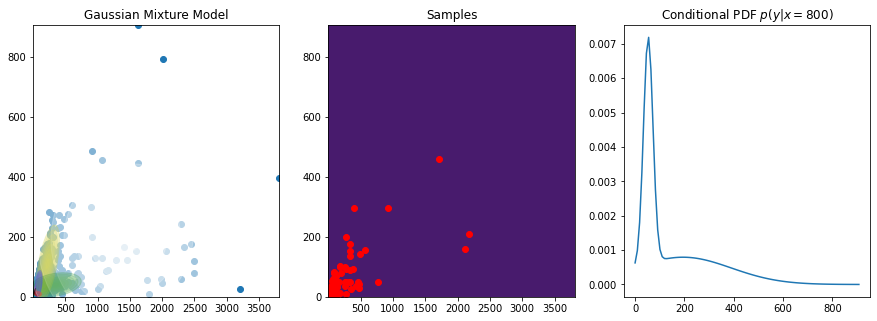

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = data.shape[0]
n_features = 2
# X = np.ndarray((n_samples, n_features))
# X[:n_samples // 3, :] = random_state.multivariate_normal(
#     [0.0, 1.0], [[0.5, -1.0], [-1.0, 5.0]], size=(n_samples // 3,))
# X[n_samples // 3:-n_samples // 3, :] = random_state.multivariate_normal(
#     [-2.0, -2.0], [[3.0, 1.0], [1.0, 1.0]], size=(n_samples // 3,))
# X[-n_samples // 3:, :] = random_state.multivariate_normal(
#     [3.0, 1.0], [[3.0, -1.0], [-1.0, 1.0]], size=(n_samples // 3,))
X = data[['Gross', 'Netpay']].values

gmm = GMM(n_components=9, random_state=random_state)
gmm.from_samples(X)
cond = gmm.condition(np.array([0]), np.array([800]))
x_min = np.min(data['Gross'].values)
x_max = np.max(data['Gross'].values)
y_min = np.min(data['Netpay'].values)
y_max = np.max(data['Netpay'].values)
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Gaussian Mixture Model")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g", "b", "r", '#d62728', 'w', 'k'])
plt.scatter(X[:, 0], X[:, 1])

plt.subplot(1, 3, 2)
plt.title("Samples")
plt.xlim((x_min, x_max))
plt.ylim((y_min, y_max))
x, y = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
X_test = np.vstack((x.ravel(), y.ravel())).T
p = gmm.to_probability_density(X_test)
p = p.reshape(*x.shape)
plt.contourf(x, y, p)
X_sampled = gmm.sample(100)
plt.scatter(X_sampled[:, 0], X_sampled[:, 1], c="r")

plt.subplot(1, 3, 3)
plt.title("Conditional PDF $p(y | x = 800)$")
X_test = np.linspace(y_min, y_max, 100)
plt.plot(X_test, cond.to_probability_density(X_test[:, np.newaxis]))

plt.show()

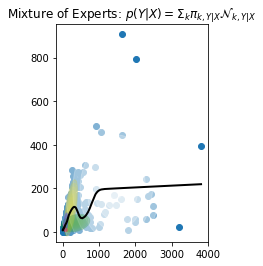

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from gmr.utils import check_random_state
from gmr import MVN, GMM, plot_error_ellipses


random_state = check_random_state(0)

n_samples = data.shape[0]
# X = np.ndarray((n_samples, 2))
# X[:, 0] = np.linspace(0, 2 * np.pi, n_samples)
# X[:, 1] = 1 - 3 * X[:, 0] + random_state.randn(n_samples)
X = data[['Gross', 'Netpay']].values


X_test = np.array(sorted(data['Gross'].values))

gmm = GMM(n_components=9, random_state=0)
gmm.from_samples(X)
Y = gmm.predict(np.array([0]), X_test[:, np.newaxis])

plt.subplot(1, 2, 2)
plt.title("Mixture of Experts: $p(Y | X) = \Sigma_k \pi_{k, Y|X} "
          "\mathcal{N}_{k, Y|X}$")
plt.scatter(X[:, 0], X[:, 1])
plot_error_ellipses(plt.gca(), gmm, colors=["c", "m", "y", "g", "b", "r", '#d62728', 'w', 'k'])
plt.plot(X_test, Y.ravel(), c="k", lw=2)

plt.show()

In [14]:
def quantile2d(x,y,Nbins,nth):
    def myperc(x,n=nth):
        return(percentile(x,n))
    t=binned_statistic(x,y,statistic=myperc,bins=Nbins)
    v=[]
    for i in range(len(t[0])): v.append((t[1][i+1]+t[1][i])/2.)
    v=np.array(v)
    return(t,v)

In [15]:
x = data['Permeability'].values
y = data['Depth'].values
Nbins=400
nth=95.
t,v=quantile2d(x,y,Nbins,nth)
ii=[]
for i in range(Nbins):
    ii=ii+np.argwhere(((t.binnumber==i) & (y<t.statistic[i]))).flatten().tolist()
ii=np.array(ii,dtype=int)

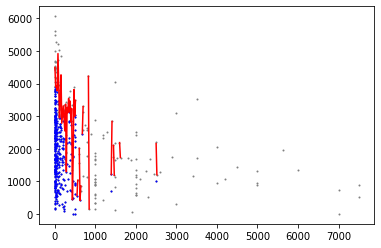

In [16]:
plt.plot(x,y,'o',color='gray',ms=1,zorder=1)
plt.plot(v,t.statistic,'r-',zorder=3)
plt.plot(x[ii],y[ii],'o',color='blue',ms=1,zorder=2)